
# Google Colab Jupyter Notebook for Profiling
---



# Preparations

In [1]:
!nvcc --version
!nvidia-smi

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2021 NVIDIA Corporation
Built on Sun_Feb_14_21:12:58_PST_2021
Cuda compilation tools, release 11.2, V11.2.152
Build cuda_11.2.r11.2/compiler.29618528_0
Tue Jan 10 14:29:33 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   47C    P0    27W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |      

In [2]:
from google.colab import drive
drive.mount('/content/drive')
%cd '/content/drive/MyDrive/Colab Notebooks/AppliedGPU_finalProject'
!ls

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Colab Notebooks/AppliedGPU_finalProject
datasets  include  Makefile  src


#Compiling

In [3]:
!make clean
!make all

rm -rf  src/terminal_user_input.o src/knn.o src/test.o
rm -rf bin/knn
rm -rf bin/test
mkdir -p bin
[ -d src ] || mkdir src
nvcc -std=c++11 -I./include -O2 -g -G -Xcompiler -Wall -lm  src/terminal_user_input.cpp -c -o src/terminal_user_input.o
nvcc -I./include -arch=sm_75 -std=c++11 -O2 -g -G -Xcompiler -Wall --compiler-bindir=g++ -lm -lnvToolsExt  src/test.cu -c -o src/test.o
nvcc -I./include -arch=sm_75 -std=c++11 -O2 -g -G -Xcompiler -Wall --compiler-bindir=g++ -lm -lnvToolsExt  src/terminal_user_input.o src/test.o -o bin/test
nvcc -I./include -arch=sm_75 -std=c++11 -O2 -g -G -Xcompiler -Wall --compiler-bindir=g++ -lm -lnvToolsExt  -DNDEBUG src/knn.cu -c -o src/knn.o
nvcc -I./include -arch=sm_75 -std=c++11 -O2 -g -G -Xcompiler -Wall --compiler-bindir=g++ -lm -lnvToolsExt  -DNDEBUG src/terminal_user_input.o src/knn.o -o bin/knn


# Executing

In [31]:
!./bin/knn

Filename: /content/drive/MyDrive/Colab Notebooks/AppliedGPU_finalProject/datasets/iris_dataset/iris.data.csv
Please put the desired number of neighbours k for the search: 5
How many query points do you want to enter?: 3
Do you want to enter the query points manually? (yes/no) If no, the query points will be chosen randomly: no
Query point ID 0 classified as: Iris-virginica
Query point ID 1 classified as: Iris-virginica
Query point ID 2 classified as: Iris-virginica


#Debugging

In [18]:
!printf "set cuda memcheck on\nset cuda api_failures stop\ncatch throw\nr\nbt\ninfo locals\nthread 1\nbt\n" > ./tmp.txt
!cuda-gdb -batch -x tmp.txt --args ./bin/knn

Catchpoint 1 (throw)
[Thread debugging using libthread_db enabled]
Using host libthread_db library "/lib/x86_64-linux-gnu/libthread_db.so.1".
Filename: /content/drive/MyDrive/Colab Notebooks/AppliedGPU_finalProject/datasets/iris_dataset/iris.data.csv
Please put the desired number of neighbours k for the search: 5
How many query points do you want to enter?: 1
Do you want to enter the query points manually? (yes/no) If no, the query points will be chosen randomly: 1
Please enter yes or no [y/n].Do you want to enter the query points manually? (yes/no) If no, the query points will be chosen randomly: yes
0th dimension: 1
1th dimension: 1
2th dimension: 1
3th dimension: 1
[Detaching after fork from child process 7576]
[New Thread 0x7f7b280cb700 (LWP 7580)]
[New Thread 0x7f7b278ca700 (LWP 7581)]

Thread 1 "knn" received signal SIGSEGV, Segmentation fault.
0x000055b5854094e6 in classify (category_map=..., category=-2035521848) at src/knn.cu:661
661	  my_string class_string = category_map.cat

#Profiling

### Gprof

In [ ]:
!gprof ./bin/knn gmon.out

Flat profile:

Each sample counts as 0.01 seconds.
  %   cumulative   self              self     total           
 time   seconds   seconds    calls  ms/call  ms/call  name    
 68.75      0.11     0.11   900001     0.00     0.00  count_fields(char*)
  6.25      0.12     0.01   900000     0.00     0.00  extract_field(my_string, int)
  6.25      0.13     0.01   100000     0.00     0.00  parse_point(my_string, int, Classifier_List*)
  6.25      0.14     0.01   100000     0.00     0.00  get_class_num(my_string, Classifier_List*)
  6.25      0.15     0.01        1    10.00    10.00  knn_search_parallel(int, comparision_point*, int, dataset*)
  6.25      0.16     0.01                             __cudart768
  0.00      0.16     0.00   100001     0.00     0.00  cudaError cudaMalloc<float>(float**, unsigned long)
  0.00      0.16     0.00        4     0.00     0.00  dim3::dim3(unsigned int, unsigned int, unsigned int)
  0.00      0.16     0.00        2     0.00     0.00  cudaError cudaMalloc<

### CUDA_PROFILE

In [ ]:
!CUDA_PROFILE=1 ./bin/knn

Point classified as: BOM_JARDIM_DA_SERRA_-_MORRO_DA_IGREJA


In [ ]:
!cat cuda_profile_1.log

cat: cuda_profile_1.log: No such file or directory


### Nsys & Nvprof

In [ ]:
!nvprof --output-profile profilingV2.nvprof ./bin/knn

In [85]:
#!nvprof --profile-childprocesses ./bin/knn
#--profile-all-processes
#--cpu-profiling on --cpu-thread-tracing on

!nsys nvprof ./bin/knn


Filename: /content/drive/MyDrive/Colab Notebooks/AppliedGPU_finalProject/datasets/weather_dataset/weather_south_500.csv
Please put the desired number of neighbours k for the search: 5
How many query points do you want to enter?: 16
Do you want to enter the query points manually? (yes/no) If no, the query points will be chosen randomly: no
Query point ID 0 classified as: BOM_JARDIM_DA_SERRA_-_MORRO_DA_IGREJA
Query point ID 1 classified as: BOM_JARDIM_DA_SERRA_-_MORRO_DA_IGREJA
Query point ID 2 classified as: BOM_JARDIM_DA_SERRA_-_MORRO_DA_IGREJA
Query point ID 3 classified as: BOM_JARDIM_DA_SERRA_-_MORRO_DA_IGREJA
Query point ID 4 classified as: BOM_JARDIM_DA_SERRA_-_MORRO_DA_IGREJA
Query point ID 5 classified as: BOM_JARDIM_DA_SERRA_-_MORRO_DA_IGREJA
Query point ID 6 classified as: BOM_JARDIM_DA_SERRA_-_MORRO_DA_IGREJA
Query point ID 7 classified as: BOM_JARDIM_DA_SERRA_-_MORRO_DA_IGREJA
Query point ID 8 classified as: BOM_JARDIM_DA_SERRA_-_MORRO_DA_IGREJA
Query point ID 9 classified 

# Analysis & Plotting

In [7]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

### Plots for different values of k

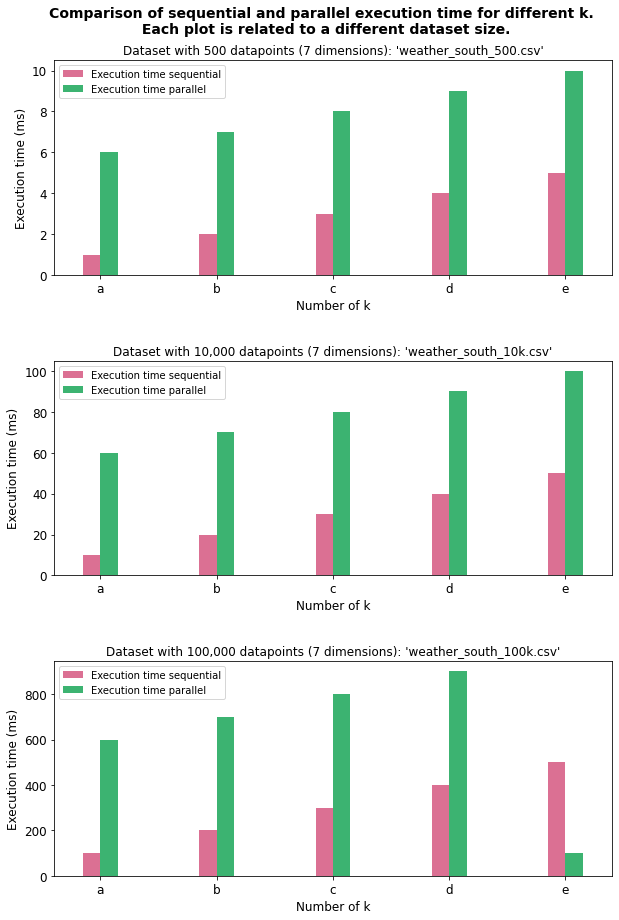

In [73]:
index_k = ['a', 'b', 'c', 'd', 'e']

execution_time_sequential_500 = [1, 2, 3, 4, 5]
execution_time_parallel_500 = [6, 7, 8, 9, 10]

execution_time_sequential_10k = [10, 20, 30, 40, 50]
execution_time_parallel_10k = [60, 70, 80, 90, 100]

execution_time_sequential_100k = [100, 200, 300, 400, 500]
execution_time_parallel_100k = [600, 700, 800, 900, 100]

df_500 = pd.DataFrame({'Execution time sequential': execution_time_sequential_500,
                   'Execution time parallel': execution_time_parallel_500,}, index=index_k)

df_10k = pd.DataFrame({'Execution time sequential': execution_time_sequential_10k,
                   'Execution time parallel': execution_time_parallel_10k,}, index=index_k)

df_100k = pd.DataFrame({'Execution time sequential': execution_time_sequential_100k,
                   'Execution time parallel': execution_time_parallel_100k,}, index=index_k)


width = 0.3

fig, axes = plt.subplots(nrows = 3, ncols = 1)

ax = df_500.plot.bar(ax = axes[0], width = width, rot = 0, alpha = 1, fontsize=12, color={"Execution time sequential": "palevioletred", "Execution time parallel": "mediumseagreen"})
ax.set_title("Dataset with 500 datapoints (7 dimensions): 'weather_south_500.csv'")
ax.set_xlabel("Number of k", fontsize=12)
ax.set_ylabel("Execution time (ms)", fontsize=12)

ax = df_10k.plot.bar(ax = axes[1], width = width, rot = 0, alpha = 1, fontsize=12, color={"Execution time sequential": "palevioletred", "Execution time parallel": "mediumseagreen"})
ax.set_title("Dataset with 10,000 datapoints (7 dimensions): 'weather_south_10k.csv'")
ax.set_xlabel("Number of k", fontsize=12)
ax.set_ylabel("Execution time (ms)", fontsize=12)

ax = df_100k.plot.bar(ax = axes[2], width = width, rot = 0, alpha = 1, fontsize=12, color={"Execution time sequential": "palevioletred", "Execution time parallel": "mediumseagreen"})
ax.set_title("Dataset with 100,000 datapoints (7 dimensions): 'weather_south_100k.csv'")
ax.set_xlabel("Number of k", fontsize=12)
ax.set_ylabel("Execution time (ms)", fontsize=12)

plt.subplots_adjust(hspace=0.4)
fig.suptitle("Comparison of sequential and parallel execution time for different k. \n Each plot is related to a different dataset size.", y=0.93, fontweight = "bold", fontsize = 14)
fig.set_size_inches(10, 15, forward=True)